<a href="https://colab.research.google.com/github/TiberiuAntoniu/Data-Science-in-industry/blob/main/Random_Forest_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Model improvement


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from seaborn import heatmap, distplot

**Data cleanup**

Remove null values and change categorical to numerical

Remove redundant columns

In [35]:
def prepare_data():
  train_data = pd.read_csv('./train.csv')
  train_data['Dependents'].replace('3+', 3, inplace=True)

  train_data['Loan_Status'].replace('N', 0, inplace=True)
  train_data['Loan_Status'].replace('Y', 1, inplace=True)

  train_data['Education'].replace('Not Graduate', 0, inplace=True)
  train_data['Education'].replace('Graduate', 1, inplace=True)

  train_data['Gender'].replace('Male', 0, inplace=True)
  train_data['Gender'].replace('Female', 1, inplace=True)

  train_data['Self_Employed'].replace('No', 0, inplace=True)
  train_data['Self_Employed'].replace('Yes', 1, inplace=True)


  train_data['Married'].replace('No', 0, inplace=True)
  train_data['Married'].replace('Yes', 1, inplace=True)

  train_data['Property_Area'].replace('Rural', 0, inplace=True)
  train_data['Property_Area'].replace('Semiurban', 1, inplace=True)
  train_data['Property_Area'].replace('Urban', 2, inplace=True)


  # replace nan values
  train_data['Dependents'].replace(np.nan, round(train_data['Dependents'][train_data['Dependents'].notnull()].astype(int).mean()), inplace=True)
  train_data['Credit_History'].replace(np.nan, round(train_data['Credit_History'][train_data['Credit_History'].notnull()].astype(int).mean()), inplace=True)
  train_data['Gender'].replace(np.nan, train_data['Gender'].mode()[0], inplace=True)
  train_data['LoanAmount'].replace(np.nan, round(train_data['LoanAmount'][train_data['LoanAmount'].notnull()].astype(int).mean()), inplace=True)
  train_data['Loan_Amount_Term'].replace(np.nan, round(train_data['Loan_Amount_Term'][train_data['Loan_Amount_Term'].notnull()].astype(int).mean()), inplace=True)
  train_data['Self_Employed'].replace(np.nan, train_data['Self_Employed'].mode()[0], inplace=True)
  train_data['Married'].replace(np.nan, train_data['Married'].mode()[0], inplace=True)

  X = train_data.copy()
  Y = train_data["Loan_Status"]

  # drop reduntant columns
  X = X.drop("Loan_ID", axis=1)
  X = X.drop("Loan_Status", axis=1)

  return train_data, X, Y

train_data, X, Y = prepare_data()

Create train function that will be used to train the model and return accuracy/recall/precision 

In [36]:
def train_func(x_train, y_train, x_test, y_test, forest_depth=6, forest_estimators=20):
  global forest_model
  forest_model = RandomForestClassifier(random_state=1, max_depth=forest_depth, n_estimators=forest_estimators)
  forest_model.fit(x_train, y_train)
  
  pred_train = forest_model.predict(x_train)
  
  score_train = accuracy_score(pred_train, y_train) * 100
  matrix_train = confusion_matrix(pred_train, y_train)
  recall_score_train = recall_score(y_train, pred_train) * 100
  precision_score_train = precision_score(y_train, pred_train) * 100

  pred_forest = forest_model.predict(x_test)
  score_forest = accuracy_score(pred_forest, y_test) * 100
  matrix_forest = confusion_matrix(pred_forest, y_test)
  recall_score_forest = recall_score(y_test, pred_forest) * 100
  precision_score_forest = precision_score(y_test, pred_forest) * 100
  
  scores = pd.DataFrame({"Random Forest train": [score_train, recall_score_train, precision_score_train],
                         "Random Forest test": [score_forest, recall_score_forest, precision_score_forest]}, 
                        index=['Accuracy', "Recall: TP/TP+FN", "Precision: TP/TP+FP"])
  return scores

Initial training run using the ml comparison model

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [38]:
initial_score = train_func(x_train, y_train, x_test, y_test)
initial_forest_model = forest_model
initial_score

,Random Forest train,Random Forest test
Accuracy,83.503055,80.487805
Recall: TP/TP+FN,99.112426,98.809524
Precision: TP/TP+FP,81.113801,78.301887


# Split Strategy

**Stratified Shuffle Split**

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in shuffle_split.split(X, Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

In [40]:
train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,83.910387,82.113821
Recall: TP/TP+FN,98.219585,97.647059
Precision: TP/TP+FP,81.930693,80.582524


# Data Analysis



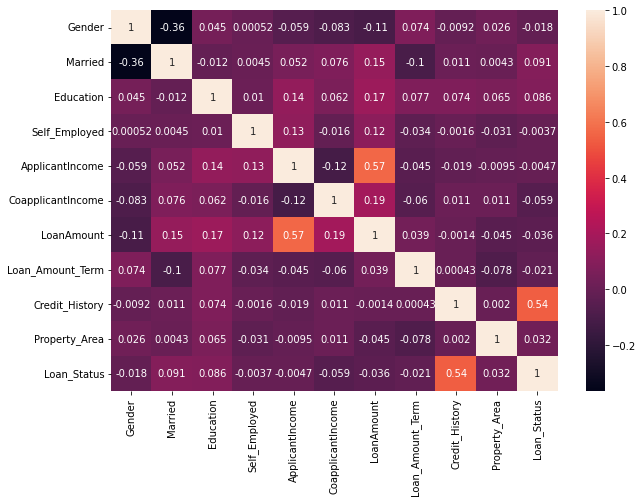

In [41]:
corr = train_data.corr()
plt.figure(figsize=(10,7))
heatmap(corr, annot=True)

LoanAmmount and ApplicantIncome have a high correlation

In [42]:
X_local = X.drop(["LoanAmount", "Loan_Amount_Term"], axis=1)

for train, test in shuffle_split.split(X_local, Y):
    X_train, X_test = X_local.iloc[train], X_local.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,82.688391,83.739837
Recall: TP/TP+FN,98.516320,100.000000
Precision: TP/TP+FP,80.582524,80.952381


In [43]:
X_local = X.drop(["ApplicantIncome", "CoapplicantIncome"], axis=1)

for train, test in shuffle_split.split(X_local, Y):
    X_train, X_test = X_local.iloc[train], X_local.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,82.892057,82.926829
Recall: TP/TP+FN,97.922849,98.823529
Precision: TP/TP+FP,81.081081,80.769231


Check different operations for "ApplicantIncome", "CoapplicantIncome", "LoanAmount" and "Loan_Amount_Term"



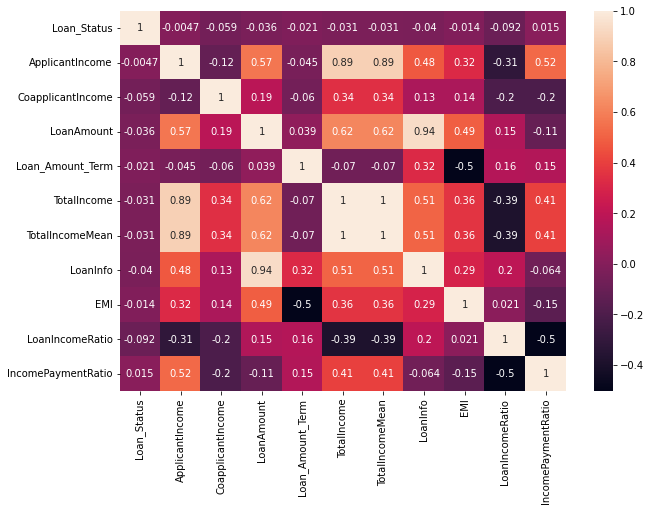

In [44]:
train_data, X, Y = prepare_data()
train_data = train_data[["Loan_Status", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]]
train_data["TotalIncome"] = train_data["ApplicantIncome"] + train_data["CoapplicantIncome"]
train_data["TotalIncomeMean"] = (train_data["ApplicantIncome"] + train_data["CoapplicantIncome"])/2
train_data["LoanInfo"] = train_data["LoanAmount"] * train_data["Loan_Amount_Term"]
train_data["EMI"] = (train_data["LoanAmount"] * 1000) / train_data["Loan_Amount_Term"]
train_data["LoanIncomeRatio"] = train_data["LoanAmount"] / train_data["TotalIncomeMean"]
train_data["IncomePaymentRatio"] = train_data["ApplicantIncome"]/ train_data["EMI"]

corr = train_data.corr()
plt.figure(figsize=(10,7))
heatmap(corr, annot=True)

TotalIncome and TotalIncomeMean have the same correlation values, i will use the mean since it has lower values

LoanInfo has a better correlation value compared to EMI so i will use LoanInfo 

I will also use LoanIncome because it has a high enough correlation



In [45]:
X["TotalIncomeMean"] = (train_data["ApplicantIncome"] + train_data["CoapplicantIncome"])/2
X["LoanInfo"] = X["LoanAmount"] * X["Loan_Amount_Term"]

In [46]:
X_new = X.drop(["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"], axis=1)

for train, test in shuffle_split.split(X_new, Y):
    X_train, X_test = X_new.iloc[train], X_new.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,84.928717,84.552846
Recall: TP/TP+FN,99.109792,98.823529
Precision: TP/TP+FP,82.469136,82.352941


In [47]:
train_data, X, Y = prepare_data()
X["TotalIncomeMean"] = (X["ApplicantIncome"] + X["CoapplicantIncome"])/2
X["LoanInfo"] = X["LoanAmount"] * X["Loan_Amount_Term"]
X["LIR"] = X["LoanAmount"] / X["TotalIncomeMean"]


train_data["TotalIncomeMean"] = (train_data["ApplicantIncome"] + train_data["CoapplicantIncome"])/2
train_data["LoanInfo"] = train_data["LoanAmount"] * train_data["Loan_Amount_Term"]
train_data["LIR"] = train_data["LoanAmount"] / train_data["TotalIncomeMean"]

In [48]:
X_new = X.drop(["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"], axis=1)

for train, test in shuffle_split.split(X_new, Y):
    X_train, X_test = X_new.iloc[train], X_new.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,86.558045,86.178862
Recall: TP/TP+FN,98.813056,96.470588
Precision: TP/TP+FP,84.303797,85.416667


In [49]:
X.drop(["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"], axis=1, inplace=True)
train_data.drop(["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"], axis=1, inplace=True)

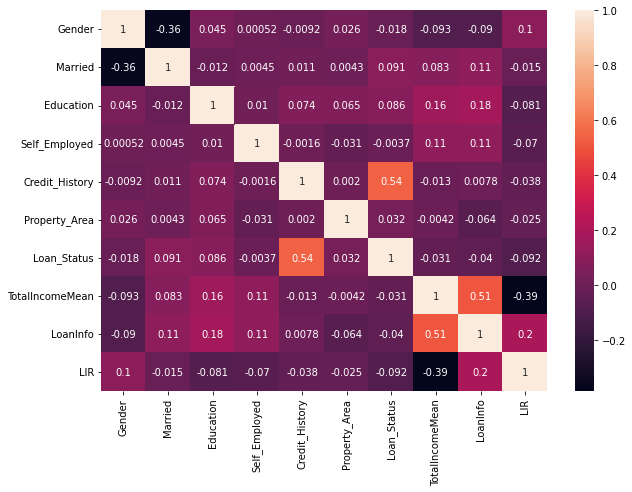

In [50]:
corr = train_data.corr()
plt.figure(figsize=(10,7))
heatmap(corr, annot=True)

Check if "Self_Employed" can be droped since it has low correlation

In [51]:
X_new = X.drop(["Self_Employed"], axis=1)

for train, test in shuffle_split.split(X_new, Y):
    X_train, X_test = X_new.iloc[train], X_new.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

train_func(X_train, y_train, X_test, y_test)

,Random Forest train,Random Forest test
Accuracy,85.132383,84.552846
Recall: TP/TP+FN,98.516320,97.647059
Precision: TP/TP+FP,83.000000,83.000000


With the current model there is a drop in accuracy after droping the column

Will try a grid search to check if a better model can be found

In [52]:
from sklearn.model_selection import GridSearchCV
params_grid_search = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), params_grid_search)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=161, random_state=1)

In [53]:
train_func(X_train, y_train, X_test, y_test, forest_depth=7, forest_estimators=161)

,Random Forest train,Random Forest test
Accuracy,86.761711,86.991870
Recall: TP/TP+FN,99.703264,97.647059
Precision: TP/TP+FP,84.000000,85.567010


With the new parameters returned by grid search there is a small improvement after removing the "Self_Employed" column

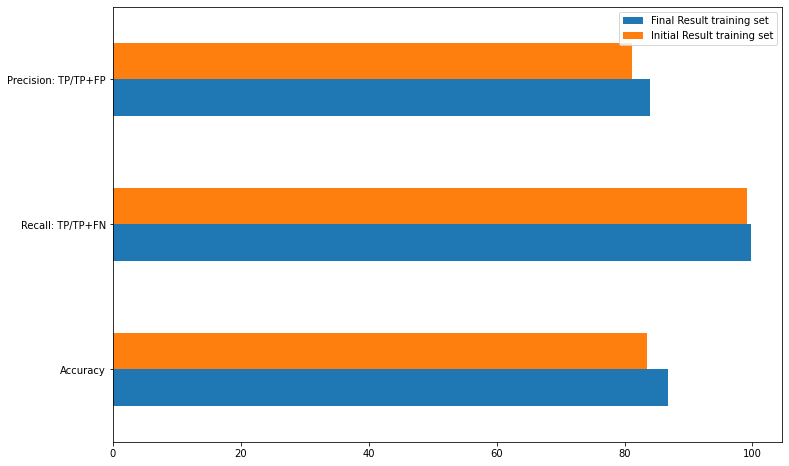

In [54]:

final_score = train_func(X_train, y_train, X_test, y_test, forest_depth=7, forest_estimators=161)

train_res = pd.DataFrame()
train_res["Final Result training set"] = final_score["Random Forest train"]
train_res["Initial Result training set"] = initial_score["Random Forest train"]
train_res.plot(kind='barh', figsize=(12, 8))

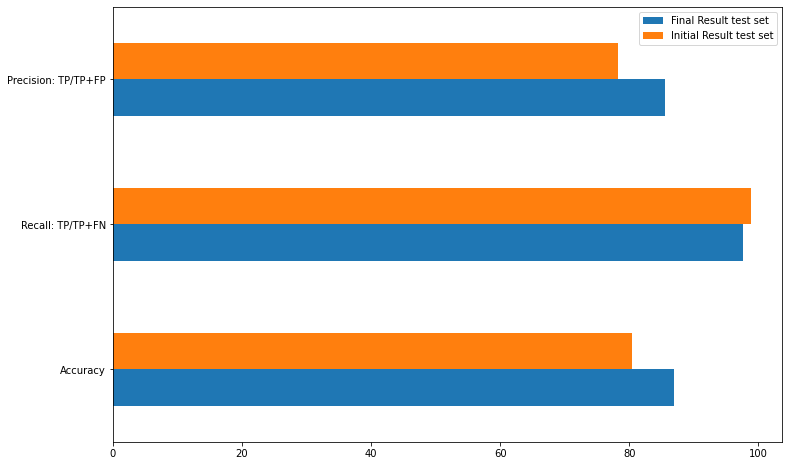

In [55]:
train_res = pd.DataFrame()
train_res["Final Result test set"] = final_score["Random Forest test"]
train_res["Initial Result test set"] = initial_score["Random Forest test"]
train_res.plot(kind='barh', figsize=(12, 8))

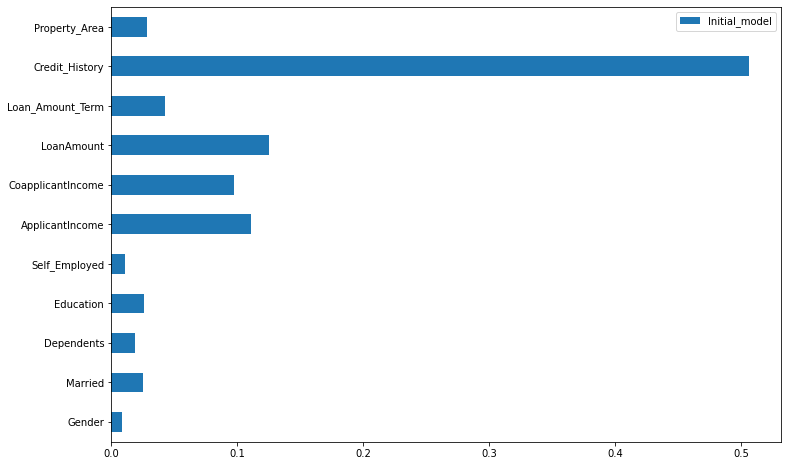

In [58]:
importance = pd.DataFrame({'Initial_model' : initial_forest_model.feature_importances_}, index=x_train.columns)
importance.plot(kind='barh', figsize=(12, 8))

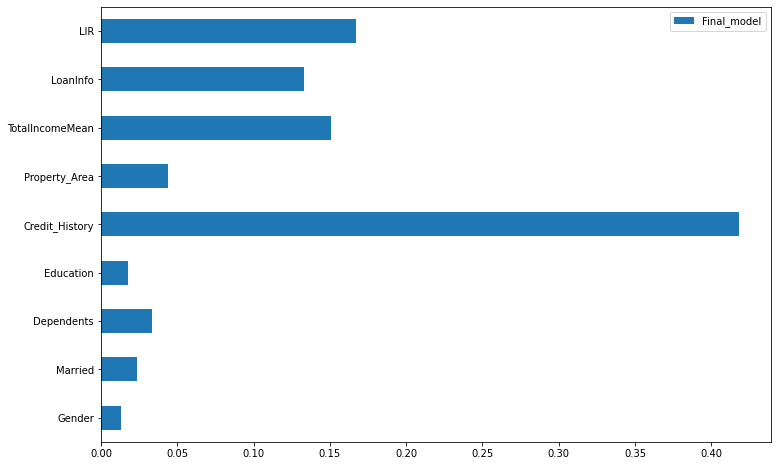

In [57]:
importance = pd.DataFrame({'Final_model' : forest_model.feature_importances_}, index=X_train.columns)
importance.plot(kind='barh', figsize=(12, 8))